# Import des modules pour tous le brief


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.metrics import mean_squared_error 


# Fonction d'affichage 

In [3]:
def plot_with_contour(model, X, y):
    plt.figure
    # Visualisation des contours de décision
    x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
    y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                         np.arange(y_min, y_max, 0.001))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=1, cmap='coolwarm')
    
    # Normalize the colormap to ignore extreme values
    # sc = plt.scatter(X[:, 0], X[:, 1], c=y, vmin=0, vmax=20_2000,
    #                 marker='o', s=5, linewidth=1, cmap='coolwarm')
    
    sc = plt.scatter(X[:, 0], X[:, 1], c=y, vmin=np.percentile(y, 5), vmax=np.percentile(y, 95), 
                     marker='o', s=5, linewidth=1, cmap='coolwarm')
    
    
    plt.colorbar(sc, label='prix m2', orientation='vertical')
    
    
    plt.title("Contours de décision de l'arbre de décision")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Phase 1 :
    Paris 4 pieces  en 2022
    

In [4]:
transactions = pd.read_csv('transactions.csv')

In [5]:
if 'Unnamed: 0' in transactions.columns:
    transactions = transactions.drop('Unnamed: 0', axis=1)
    
transactions['prix_m2'] = transactions['prix'] / (transactions['surface_habitable'])




C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\2495372181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_df[c + '_sum'] = paris_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\2495372181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_df[c + '_sum'] = paris_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\2495372181.py:4: SettingWithCopyWarning

<Axes: >

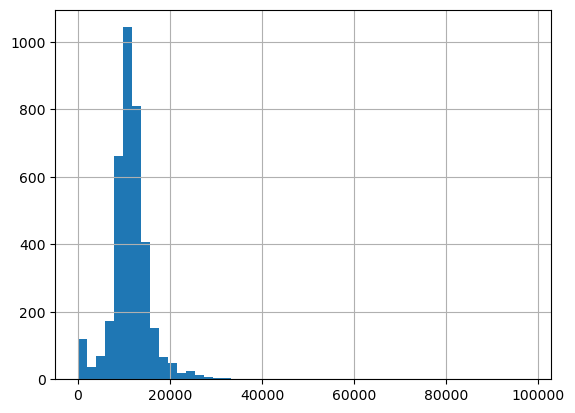

In [6]:
paris_df = transactions[(transactions.departement == 75) & (transactions.n_pieces == 4) & (transactions.date_transaction.str.startswith('2022-'))]
surface_cols = [c for c in paris_df.columns if 'surface_' in c and c != 'surface_habitable']
for c in surface_cols:
    paris_df[c + '_sum'] = paris_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
paris_df = paris_df[paris_df[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]

paris_df.prix_m2.hist(bins=50)

Text(0.5, 1.0, 'repartition des prix au m2 a Paris ')

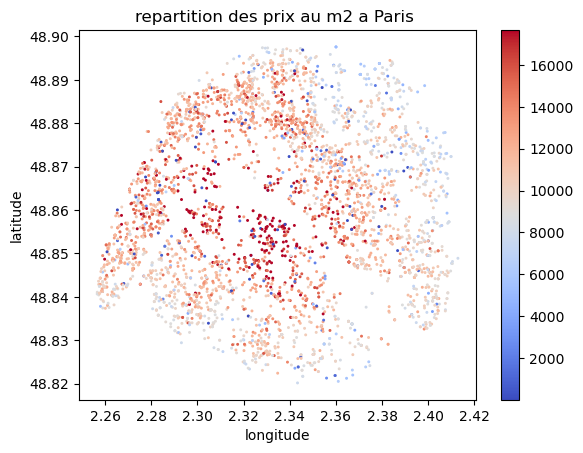

In [7]:
X = paris_df[['longitude', 'latitude']].values
y = paris_df['prix_m2'].values
plt.scatter( paris_df['longitude'] , paris_df['latitude'],marker=".",s=5,c=y,vmin=np.percentile(y,0),vmax=np.percentile(y,95),norm='linear',cmap='coolwarm')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("repartition des prix au m2 a Paris ")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from  sklearn.model_selection import GridSearchCV
from tqdm import tqdm
params_grid = {
                'LR': {
                    'model': LinearRegression(),
                    'params': {
                        'fit_intercept': [True, False],
                        'positive': [True, False]
                    }
                },
                'DTR': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                        'max_depth': list(range(1, 100,10)),
                        
                    }
                },
                'RDF': {
                    'model': RandomForestRegressor() ,
                    'params':{'max_depth' : list(range(1,100,10)),
                               'min_samples_leaf': list(range(1,10)),
                                'n_estimators' : list(range(1,10,1))
                            }

                
                }
            }

for model_name, model_config in tqdm(params_grid.items()):
    gs = GridSearchCV(estimator=model_config['model'], 
                      param_grid=model_config['params'],n_jobs=-1)
    gs.fit(X_train, y_train)
    print(f'Modèle: {model_name} avec params optimaux: {gs.best_params_} donne erreur =')
    print(np.sqrt(mean_squared_error(y_test, gs.best_estimator_.predict(X_test))))

Train 1137.2610975997316.<br>
Test 4895.481668955992.<br>
ratio 23.230831499411238.<br>
 67%|██████▋   | 2/3 [00:00<00:00, 10.34it/s]<br>
Modèle: LR avec params optimaux: {'fit_intercept': False, 'positive': False} donne erreur =
3876.875872111939<br>
Modèle: DTR avec params optimaux: {'max_depth': 1} donne erreur =
3829.644878392137<br>
100%|██████████| 3/3 [00:27<00:00,  9.27s/it]<br>
Modèle: RDF avec params optimaux: {'max_depth': 11, 'min_samples_leaf': 7, 'n_estimators': 8} donne erreur =
3395.6316897123424<br>


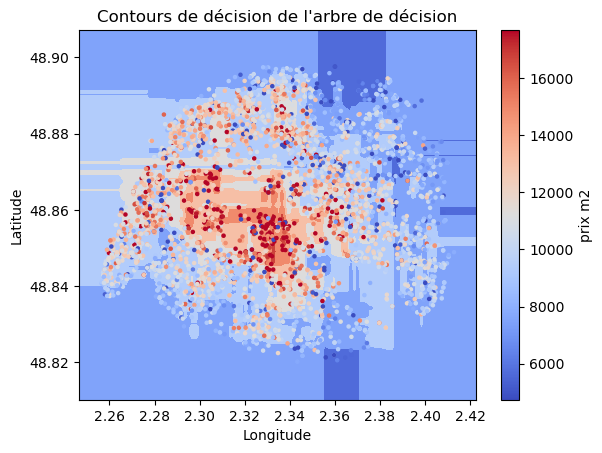

2845.053690267647


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(max_depth=11, min_samples_leaf=7, n_estimators=8)
model1.fit(X, y)
plot_with_contour(model1,X,y)
print(np.sqrt(mean_squared_error(y_test, model1.predict(X_test))))


# Phase 2 : 
    ile de France 2022

In [9]:

ile_de_france_df = transactions[(transactions.departement.isin([75,77,78,91,92,93,95,94])) & (transactions.date_transaction.str.startswith('2022-'))]
surface_cols = [c for c in ile_de_france_df.columns if 'surface_' in c and c != 'surface_habitable']
for c in surface_cols:
    ile_de_france_df[c + '_sum'] = ile_de_france_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
ile_de_france_df = ile_de_france_df[ile_de_france_df[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]





C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\3988745636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ile_de_france_df[c + '_sum'] = ile_de_france_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\3988745636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ile_de_france_df[c + '_sum'] = ile_de_france_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8092\3988745

<Axes: >

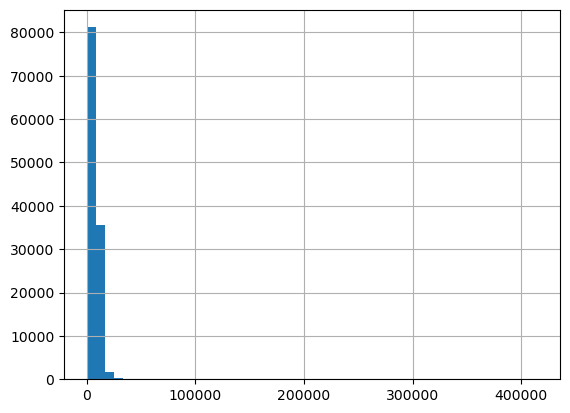

In [17]:
ile_de_france_df.prix_m2.hist(bins=50)

Text(0.5, 1.0, 'repartition des prix au m2 a en ile de france')

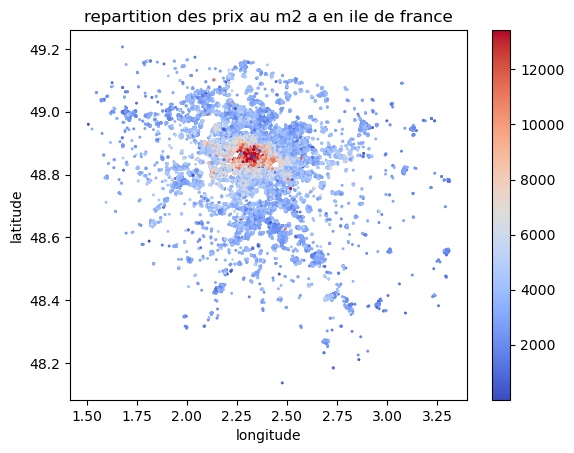

In [18]:
X = ile_de_france_df[['longitude', 'latitude']].values
y = ile_de_france_df['prix_m2'].values
plt.scatter( data['longitude'] , data['latitude'],marker=".",s=5,c=y,vmin=np.percentile(y,0),vmax=np.percentile(y,95),norm='linear',cmap='coolwarm')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("repartition des prix au m2 a en ile de france")

In [36]:
data=ile_de_france_df[['n_pieces','surface_habitable','latitude', 'longitude','departement','prix_m2','vefa', 'type_batiment']]
data=pd.get_dummies(data,columns=['type_batiment'],dtype=int)
features_names=['departement','n_pieces','vefa','surface_habitable','latitude', 'longitude']
#'type_batiment_Maison','type_batiment_Appartement' 'type_batiment',
X = data[features_names].values
y = data['prix_m2'].values



In [38]:

model2 = RandomForestRegressor(max_depth=5,verbose=True,n_jobs=-1)
model2.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


RandomForestRegressor(max_depth=5, n_jobs=-1, verbose=True)

In [39]:
print(np.sqrt(mean_squared_error(y, model2.predict(X))))

2665.5485303049622


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


<Axes: >

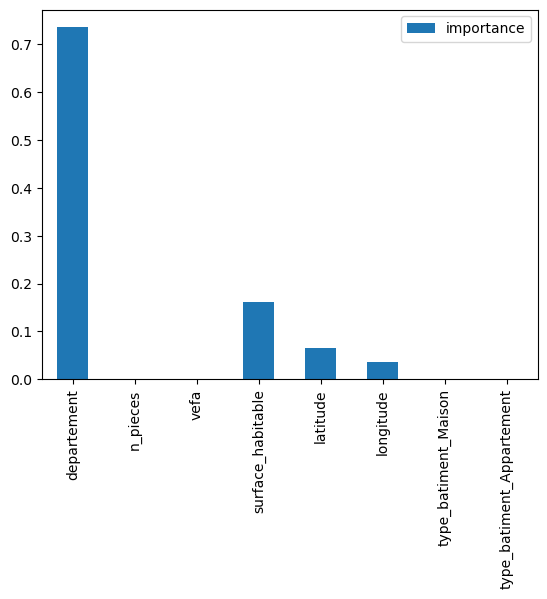

In [40]:
pd.DataFrame(model2.feature_importances_,index=features_names,columns=['importance']).plot.bar()



In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(max_depth=50,verbose=True,n_jobs=-1)
model2.fit(X_train, y_train)
print(np.sqrt(mean_squared_error(y_test, model2.predict(X_test))))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


3081.9447581536283


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


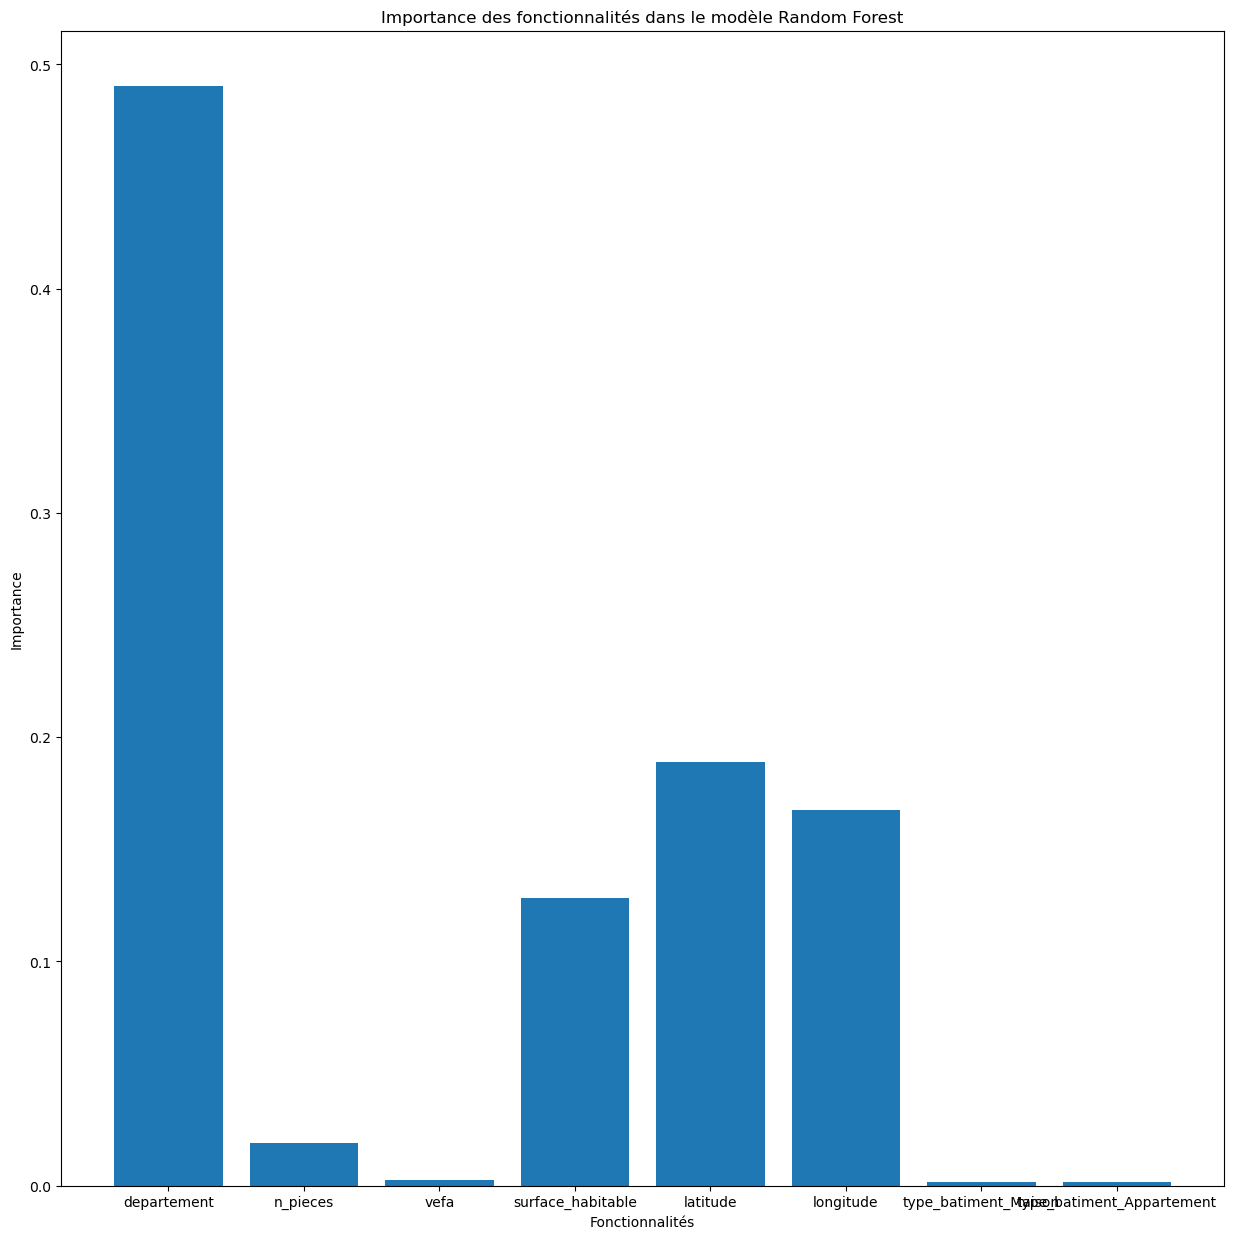

In [24]:
plt.figure(figsize=[15,15])
plt.bar(features_names,model2.feature_importances_)
plt.xlabel('Fonctionnalités')
plt.ylabel('Importance')
plt.title('Importance des fonctionnalités dans le modèle Random Forest')
plt.show()

In [42]:
np.sqrt(mean_squared_error(y_test, model2.predict(X_test)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


3081.9447581536283

In [33]:
from  sklearn.model_selection import GridSearchCV
from tqdm import tqdm
params_grid = {
                'LR': {
                    'model': LinearRegression(),
                    'params': {
                        'fit_intercept': [True, False],
                        'positive': [True, False]
                    }
                },
                'DTR': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                        'max_depth': list(range(1, 100,10)),
                        
                    }
                },
                'RDF': {
                    'model': RandomForestRegressor() ,
                    'params':{'max_depth' : list(range(1,100,20)),
                               'min_samples_leaf': list(range(1,20)),
                                'n_estimators' : list(range(1,10,2))
                            }

                
                }
            }

for model_name, model_config in tqdm(params_grid.items()):
    gs = GridSearchCV(estimator=model_config['model'], 
                      param_grid=model_config['params'],n_jobs=-1)
    gs.fit(X_train, y_train)
    print(f'Modèle: {model_name} avec params optimaux: {gs.best_params_} donne erreur =')
    print(np.sqrt(mean_squared_error(y_test, gs.best_estimator_.predict(X_test))))

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:03<00:07,  3.77s/it]

Modèle: LR avec params optimaux: {'fit_intercept': False, 'positive': False} donne erreur =
4475.880953858128


 67%|██████▋   | 2/3 [00:12<00:06,  6.70s/it]

Modèle: DTR avec params optimaux: {'max_depth': 11} donne erreur =
4610.863035703888


 67%|██████▋   | 2/3 [11:30<05:45, 345.39s/it]


KeyboardInterrupt: 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(max_depth=50,verbose=True,n_jobs=-1)
model2.fit(X_train, y_train)
print(np.sqrt(mean_squared_error(y_test, model2.predict(X_test))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s


3139.1555636487055


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [46]:
import pickle

# open a file, where you ant to store the data
file = open('model1', 'wb')

# dump information to that file
pickle.dump(model1, file)

# close the file
file.close()

# open a file, where you ant to store the data
file = open('model2', 'wb')

# dump information to that file
pickle.dump(model2, file)

# close the file
file.close()

